# Patterns of engraftment

Of the ASVs or mgx species that engraft in each patient, what portion engraft durably versus temporarily?

We'll define these two categories thus:

Engraftment: a given unit absent in the patient at baseline is present in the donor and in the patient after FMT in at least 3 samples

1. Durable engraftment: after the unit appears in the patient, it must be present in the majority of remaining samples from that patient including 1 of the two last samples from that patient

2. Temporary engraftment: everything else

In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from io import StringIO
from skbio import TreeNode
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
def relative_abundance_tidy(df, sample_col, value_col,
                            rel_abun_name='rel_abun'):
    """
    Take a tidy table, where the samples are in sample_col and the values
    to be converted to relative abundance are in value_col.
    
    sample_col can also be a list of columns
    """
    #define relatibe abundance calculation
    rel_abun = lambda x: (x / x.sum())
    #calculate new values
    values = df.groupby(sample_col)[value_col].transform(rel_abun)
    values = values.rename(rel_abun_name)
    #add to df and return
    df = pd.concat([df, values], axis=1)
    return df

In [3]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [4]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object',
                                  'fmt_induction': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [5]:
#read in 16S data
otu_ftab = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f.tsv',
                       sep='\t', index_col=0).astype(int)
otu_rare = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/dd_asv_tab_f_rare8500.tsv',
                       sep='\t', index_col=0).astype(int)

#read in taxa
taxa = pd.read_csv('/Users/ndchu/Documents/uc_fmt/16S/dada2_AG302018/taxonomy.tsv',
                   sep='\t')
taxa[['domain', 'phylum', 'class',
      'order', 'family', 'genus',
      'species']] = taxa['Taxon'].str.split(';', expand=True)
taxa = taxa.rename(columns={'Feature ID': '#OTU ID'})

In [6]:
#read in meatgenomics
mtphl = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/metaphlan/deepdive_metaphlan_tax_abun.tsv.gz',
                    sep='\t', index_col=0)
#add taxa level
mtphl.loc[:, 'taxa_level'] = mtphl.index.str.count('\|') + 1

In [7]:
#make a tidy dataframes
otu_tidy = otu_ftab.reset_index().melt(id_vars='#OTU ID', 
                                       var_name='sample_id',
                                       value_name='count')
otu_tidy = otu_tidy.loc[otu_tidy['count'] > 0]
#add relative abundance
otu_tidy = relative_abundance_tidy(otu_tidy, 'sample_id', 'count')
#add metadata
otu_tidy = otu_tidy.merge(md)

#get mgx
mtphl_md = mtphl.reset_index().rename(columns={'sample': 
                                               'sample_id'}).merge(md)
#get only species
mtphl_md_sp = mtphl_md.loc[mtphl_md['taxa_level'] == 7]

In [8]:
#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get donor otus
otu_0044 = set(otu_ftab[sam_0044].loc[otu_ftab[sam_0044].astype(bool).any(axis=1)].index)
otu_0073 = set(otu_ftab[sam_0073].loc[otu_ftab[sam_0073].astype(bool).any(axis=1)].index)

donor_otus_dict = {'0044': otu_0044, '0073': otu_0073}

#get donor species
sp_0044 = set(mtphl_md_sp.loc[mtphl_md_sp['sample_id'].isin(sam_0044)]['taxa'])
sp_0073 = set(mtphl_md_sp.loc[mtphl_md_sp['sample_id'].isin(sam_0073)]['taxa'])

donor_sp_dict = {'0044': sp_0044, '0073': sp_0073}

In [50]:
pat_id_dict = md_pat.set_index('patient').to_dict()['label_pub']
pat_id_plt_dict = {f'patient_{k}': v for k, v in pat_id_dict.items()}

## 16S

In [39]:
#look at engraftment patterns of engrated otus
eng_cat_res = []

for patient, pat_df in otu_tidy.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    if pat_df['treatment'].iloc[0] == 'placebo':
        continue
    
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_otus = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['#OTU ID'])
    
    #get donor otus
    donor_otus = donor_otus_dict[pat_df['fmt_induction'].iloc[0]]
    
    #get otus that occur at least 3 times
    tmp = pat_df.loc[pat_df['days_past_fmt'] > 0].groupby('#OTU ID').size()
    s3_otus = set(tmp.loc[tmp > 3].index)
    
    #get shared otus
    shared_otus = s3_otus & bl_otus & donor_otus
    for otu in shared_otus:
        eng_cat_res.append([patient, otu, 'shared'])
    
    #get engrafted otus
    eng_otus = (s3_otus - bl_otus) & donor_otus
    
    #get the time points for this patient
    time_pts = sorted(pat_df['days_past_fmt'].unique())
    time_pts = [x for x in time_pts if x > 0]
    
    #categorize otus into durable and temporary
    for otu in eng_otus:
        tmp_df = pat_df.loc[pat_df['#OTU ID'] == otu]
        otu_time_pts = tmp_df['days_past_fmt'].unique()
        n_time_pts = tmp_df['days_past_fmt'].nunique()
        first_time = tmp_df['days_past_fmt'].min()
        n_possible = len([x for x in time_pts if x >= first_time])
        
        if n_time_pts > n_possible / 2:
            if len(set(time_pts[-2:]) & set(otu_time_pts)) > 0:
                eng_cat_res.append([patient, otu, 'persistent'])
            else:
                eng_cat_res.append([patient, otu, 'temporary'])
        else:
            eng_cat_res.append([patient, otu, 'temporary'])

eng_cat = pd.DataFrame(eng_cat_res, columns=['patient', '#OTU ID', 'eng_category'])

In [40]:
#get the number of durable versus temp
number_per_pat = eng_cat.groupby(['patient', 'eng_category']).size().reset_index()
number_per_pat = number_per_pat.rename(columns={0: 'n_otus'})

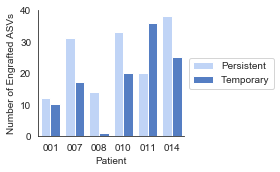

In [43]:
plt_df = number_per_pat.loc[number_per_pat['eng_category'] != 'shared']

fig = plt.figure(figsize = (4,2.5))

ax = sns.barplot(x='patient', y='n_otus', hue='eng_category',
                 data=plt_df, palette={'persistent': (0.7176470588235294, 0.8235294117647058, 1.0),
                                               'temporary': (0.25882352941176473, 0.4745098039215686, 0.8392156862745098)})
ax.set_ylabel('Number of Engrafted ASVs')
ax.set_xlabel('Patient')
legend = ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
legend.get_texts()[0].set_text('Persistent')
legend.get_texts()[1].set_text('Temporary')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/durable_temporary_eng_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/durable_temporary_eng_2019-05-22.pdf',
            dpi=300)

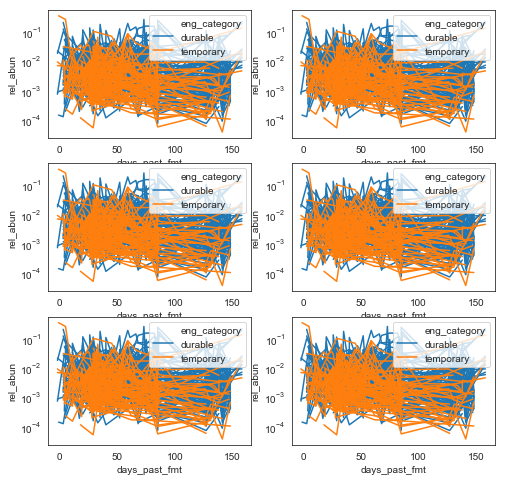

In [70]:
#plot the timelines of these ASVs as well
plt_df = otu_tidy.merge(eng_cat)

fig = plt.figure(figsize = (8,8))

counter = 1
for patient, pat_df in plt_df.groupby('patient'):
    ax = fig.add_subplot(3,2,counter)
    
    sns.lineplot(x='days_past_fmt', y='rel_abun',
                 data=plt_df, hue='eng_category',
                 units='#OTU ID', estimator=None)
    
    ax.set_yscale('log')
    
    counter += 1

### Look at the number of shared, patient, donor, and transferred

In [26]:
#for 16S
sharing_res = []

for patient, pat_df in otu_tidy.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    if pat_df['treatment'].iloc[0] == 'placebo':
        continue
    
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_otus = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['#OTU ID'])
    
    #get donor otus
    donor_otus = donor_otus_dict[pat_df['fmt_induction'].iloc[0]]
    
    #get otus that occur at least 3 times
    tmp = pat_df.loc[pat_df['days_past_fmt'] > 0].groupby('#OTU ID').size()
    s3_otus = set(tmp.loc[tmp > 3].index)
    
    #get shared otus
    shared_otus = s3_otus & bl_otus & donor_otus
    for otu in shared_otus:
        eng_cat_res.append([patient, otu, 'shared'])
    
    #get engrafted otus
    eng_otus = (s3_otus - bl_otus) & donor_otus
    
    #get donor specific
    donor_sp_otus = donor_otus - bl_otus
    
    #get patient specific
    pat_sp_otus = bl_otus - donor_otus
    
    for otu in shared_otus:
        sharing_res.append([patient, otu, 'shared'])
    for otu in pat_sp_otus:
        sharing_res.append([patient, otu, 'patient'])
    for otu in donor_sp_otus:
        sharing_res.append([patient, otu, 'donor'])
    for otu in eng_otus:
        sharing_res.append([patient, otu, 'colonized'])

sharing_df = pd.DataFrame(sharing_res, columns=['patient', '#OTU ID', 'shr_category'])

In [27]:
#get the number of durable versus temp
sharing_ct_df = sharing_df.groupby(['patient', 'shr_category']).size().reset_index()
sharing_ct_df = sharing_ct_df.rename(columns={0: 'n_otus'})

In [49]:
sharing_ct_df['patient'].unique()

array(['001', '007', '008', '010', '011', '014'], dtype=object)

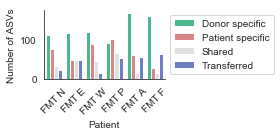

In [55]:
fig = plt.figure(figsize = (4,2))

ax = sns.barplot(x='patient', y='n_otus', hue='shr_category',
                 data=sharing_ct_df, palette={'shared': (0.878, 0.878, 0.878),
                                              'patient': (0.909, 0.470, 0.470),
                                              'donor': (0.214, 0.796, 0.570),
                                              'colonized': (0.376, 0.470, 0.803)},
                 hue_order=['donor', 'patient', 'shared', 'colonized']
                )
ax.set_ylabel('Number of ASVs')
ax.set_xlabel('Patient')

#set xtick labels
labels = [pat_id_dict[x] for x in sharing_ct_df['patient'].unique()]
ax.set_xticklabels(labels, rotation=45)

legend = ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
legend.get_texts()[0].set_text('Donor specific')
legend.get_texts()[1].set_text('Patient specific')
legend.get_texts()[2].set_text('Shared')
legend.get_texts()[3].set_text('Transferred')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/shared_ct_eng_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/shared_ct_eng_2019-05-22.pdf',
            dpi=300)

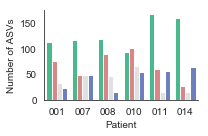

In [45]:
#No legend
fig = plt.figure(figsize = (3,2))

ax = sns.barplot(x='patient', y='n_otus', hue='shr_category',
                 data=sharing_ct_df, palette={'shared': (0.878, 0.878, 0.878),
                                              'patient': (0.909, 0.470, 0.470),
                                              'donor': (0.214, 0.796, 0.570),
                                              'colonized': (0.376, 0.470, 0.803)},
                 hue_order=['donor', 'patient', 'shared', 'colonized']
                )
ax.set_ylabel('Number of ASVs')
ax.set_xlabel('Patient')
ax.legend_.remove()

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/shared_ct_eng_nolgnd_2019-05-22.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/shared_ct_eng_nolgnd_2019-05-22.pdf',
            dpi=300)

## MGX

Do the same for MGX data

In [46]:
#look at engraftment patterns of engrated otus
eng_cat_res_mgx = []

for patient, pat_df in mtphl_md_sp.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    if pat_df['treatment'].iloc[0] == 'placebo':
        continue
    
    #get patient baseline otus
    bl_sam = md.loc[(md['patient'] == patient) & \
                    (md['days_past_fmt'] < -5)]['sample_id'].tolist()
    bl_taxa = set(pat_df.loc[pat_df['sample_id'].isin(bl_sam)]['taxa'])
    
    #get donor otus
    donor_taxa = donor_sp_dict[pat_df['fmt_induction'].iloc[0]]
    
    #get otus that occur at least 3 times
    tmp = pat_df.loc[pat_df['days_past_fmt'] > 0].groupby('taxa').size()
    s3_taxa = set(tmp.loc[tmp > 3].index)
    
    #get engrated otus
    eng_taxa = (s3_taxa - bl_taxa) & donor_taxa
    
    #get the time points for this patient
    time_pts = sorted(pat_df['days_past_fmt'].unique())
    time_pts = [x for x in time_pts if x > 0]
    
    #categorize otus
    for taxa in eng_taxa:
        tmp_df = pat_df.loc[pat_df['taxa'] == taxa]
        taxa_time_pts = tmp_df['days_past_fmt'].unique()
        n_time_pts = tmp_df['days_past_fmt'].nunique()
        first_time = tmp_df['days_past_fmt'].min()
        n_possible = len([x for x in time_pts if x >= first_time])
        
        if n_time_pts > n_possible / 2:
            if len(set(time_pts[-2:]) & set(taxa_time_pts)) > 0:
                eng_cat_res_mgx.append([patient, taxa, 'persistent'])
            else:
                eng_cat_res_mgx.append([patient, taxa, 'temporary'])
        else:
            eng_cat_res_mgx.append([patient, taxa, 'temporary'])

eng_cat_mgx = pd.DataFrame(eng_cat_res_mgx, columns=['patient', 
                                                     'taxa', 
                                                     'eng_category'])

In [47]:
#get the number of durable versus temp
number_per_pat_mgx = eng_cat_mgx.groupby(['patient', 
                                          'eng_category']).size().reset_index()
number_per_pat_mgx = number_per_pat_mgx.rename(columns={0: 'n_taxa'})

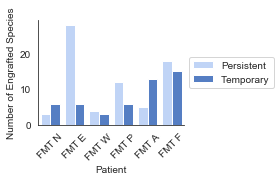

In [56]:
#plot for mgx
fig = plt.figure(figsize = (4,2.5))

ax = sns.barplot(x='patient', y='n_taxa', hue='eng_category',
                 data=number_per_pat_mgx, 
                 palette={'persistent': (0.7176470588235294, 0.8235294117647058, 1.0),
                          'temporary': (0.25882352941176473, 0.4745098039215686, 0.8392156862745098)})
ax.set_ylabel('Number of Engrafted Species')
ax.set_xlabel('Patient')
legend = ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
legend.get_texts()[0].set_text('Persistent')
legend.get_texts()[1].set_text('Temporary')

#set xtick labels
labels = [pat_id_dict[x] for x in sharing_ct_df['patient'].unique()]
ax.set_xticklabels(labels, rotation=45)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/durable_temporary_engmgx_2019-04-11.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/durable_temporary_engmgx_2019-04-11.pdf',
            dpi=300)

## What taxa engraft the most often? Which ones the least?

The data from donor 0073 aren't as valuable, since there are half the number of recipients.

In [31]:
#get number of durable and temp engratment patients for each otu
npat_eng_all = eng_cat.groupby(['#OTU ID', 'eng_category']).size()
npat_eng_all = npat_eng_all.rename('n_patients_eng').reset_index()
npat_eng_d44 = eng_cat.loc[eng_cat['patient'].isin(['001', '007', 
                                                    '010', '014'])].groupby(['#OTU ID', 
                                                                             'eng_category']).size()
npat_eng_d44 = npat_eng_d44.rename('n_patients_eng').reset_index()
npat_eng_d73 = eng_cat.loc[eng_cat['patient'].isin(['008', '011'])].groupby(['#OTU ID', 
                                                                             'eng_category']).size()
npat_eng_d73 = npat_eng_d73.rename('n_patients_eng').reset_index()

In [42]:
#compare to the donor otus
d44_all_eng = npat_eng_all.merge(pd.DataFrame({'#OTU ID': list(otu_0044)}),
                                 how='outer')
d44_all_eng.loc[:, 'n_patients_eng'] = d44_all_eng['n_patients_eng'].fillna(0)

d73_all_eng = npat_eng_all.merge(pd.DataFrame({'#OTU ID': list(otu_0073)}),
                                 how='outer')
d73_all_eng.loc[:, 'n_patients_eng'] = d73_all_eng['n_patients_eng'].fillna(0)

#this is the most useful table
d44_pat44_eng = npat_eng_d44.merge(pd.DataFrame({'#OTU ID': list(otu_0044)}),
                                 how='outer')
d44_pat44_eng.loc[:, 'n_patients_eng'] = d44_pat44_eng['n_patients_eng'].fillna(0)
#
d73_pat73_eng = npat_eng_d73.merge(pd.DataFrame({'#OTU ID': list(otu_0044)}),
                                 how='outer')
d73_pat73_eng.loc[:, 'n_patients_eng'] = d73_pat73_eng['n_patients_eng'].fillna(0)

In [44]:
#get mean and median values from each donor
d44_mean = otu_tidy.loc[otu_tidy['patient'] == '0044'].groupby('#OTU ID').mean()['rel_abun']
d44_mean = d44_mean.rename('donor_44_mean')
d44_med = otu_tidy.loc[otu_tidy['patient'] == '0044'].groupby('#OTU ID').median()['rel_abun']
d44_med = d44_med.rename('donor_44_med')

d73_mean = otu_tidy.loc[otu_tidy['patient'] == '0073'].groupby('#OTU ID').mean()['rel_abun']
d73_mean = d73_mean.rename('donor_73_mean')
d73_med = otu_tidy.loc[otu_tidy['patient'] == '0073'].groupby('#OTU ID').median()['rel_abun']
d73_med = d73_med.rename('donor_73_med')

#look at the d44 results
d44_all_eng = d44_all_eng.merge(d44_mean.reset_index())
d44_all_eng = d44_all_eng.merge(d44_med.reset_index())

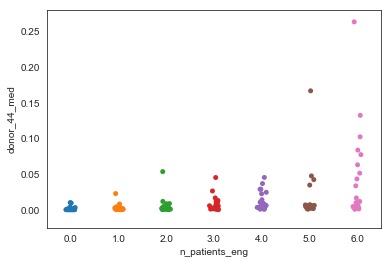

In [82]:
#plot the number 
plt_df = d44_all_eng.groupby('#OTU ID').sum()
sns.stripplot(x='n_patients_eng', y='donor_44_med',
              data=plt_df)

### Focus on d44 patients, otus, and median abundance in d44

In [45]:
#look at the d44 results
d44_pat44_eng = d44_pat44_eng.merge(d44_med.reset_index())

#add taxa
d44_pat44_eng = d44_pat44_eng.merge(taxa)
#sort
d44_pat44_eng = d44_pat44_eng.sort_values(['eng_category',
                                         'n_patients_eng'], ascending=[True, 
                                                                       False])

In [37]:
#write to a table
npat_eng_d44.to_csv('/Users/ndchu/Documents/uc_fmt/microbiome_ms/supp_tables_files/d44_trans_otus_npats_2019-05-05.tsv.gz',
                    sep='\t', index=False, compression='gzip')

In [40]:
d44_eng_otus_any = set(npat_eng_d44['#OTU ID'])

len(otu_0044 - d44_eng_otus_any)

39

In [41]:
len(d44_eng_otus_any)

137

In [47]:
d44_pat44_eng['n_patients_eng'].unique()

array([4., 3., 2., 1.])